In [4]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")


df = pd.read_csv(os.getenv("MEDIAN_CENTERED"),index_col=0)

zscored_df = pd.read_csv(os.getenv("ZSCORED"),index_col=0)

clinical_df = pd.read_csv(os.getenv("CLINICAL"),index_col=0)

# Set title as index
#clinical_df_indexed = clinical_df.set_index("title")
clinical_df_indexed = clinical_df.copy()

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


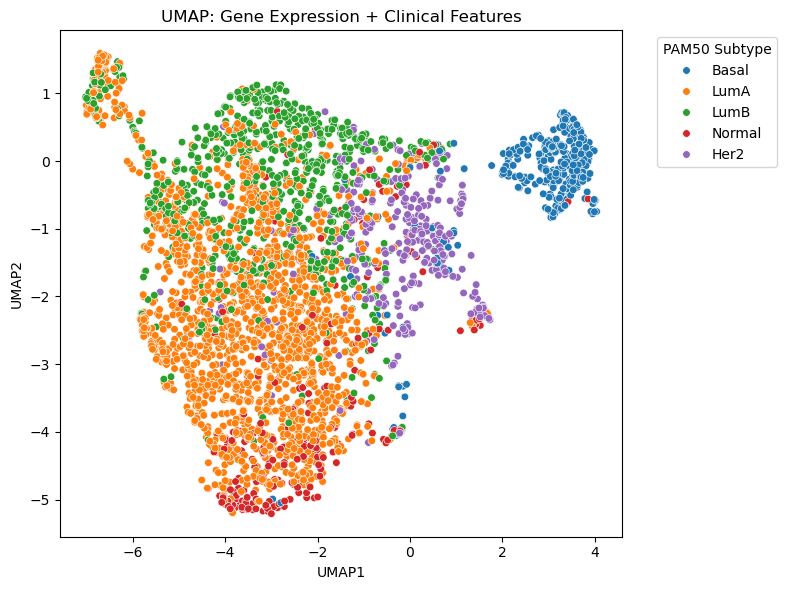

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 0: Select and clean clinical features ---
id_columns = [
    'last_update_date__Mar 12 2018',
    'last_update_date__May 04 2022',
    'instrument model__HiSeq 2000',
    'instrument model__NextSeq 500',
    "er prediction mgc", "pgr prediction mgc", "her2 prediction mgc", "ki67 prediction mgc",
    "nhg prediction mgc", "er prediction sgc", "pgr prediction sgc", "her2 prediction sgc", "ki67 prediction sgc"
]

# Keep numeric clinical columns only
clinical_features = clinical_df_indexed.select_dtypes(include=[np.number]).drop(columns=[col for col in id_columns if col in clinical_df_indexed.columns])

# Align sample indices
clinical_features = clinical_features.loc[zscored_df.index]

# --- Step 1: Separate column types ---
onehot_cols = [col for col in clinical_features.columns if set(clinical_features[col].dropna().unique()) <= {0, 1}]
numeric_cols = [col for col in clinical_features.columns if col not in onehot_cols]

# --- Step 2: Impute missing values ---
imp_num = SimpleImputer(strategy="mean")
imp_bin = SimpleImputer(strategy="constant", fill_value=0)

clinical_numeric = pd.DataFrame(imp_num.fit_transform(clinical_features[numeric_cols]), 
                                columns=numeric_cols, index=clinical_features.index)

clinical_onehot = pd.DataFrame(imp_bin.fit_transform(clinical_features[onehot_cols]), 
                               columns=onehot_cols, index=clinical_features.index)

clinical_imputed = pd.concat([clinical_numeric, clinical_onehot], axis=1)

# --- Step 3: Reduce gene expression with PCA ---
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(zscored_df)

# --- Step 4: Scale clinical features ---
scaler = StandardScaler()
clinical_scaled = scaler.fit_transform(clinical_imputed)

# --- Step 5: Combine expression + clinical ---
X_combined = np.hstack((X_pca, clinical_scaled))

# --- Step 6: UMAP projection ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_combined)

# --- Step 7: Create DataFrame for downstream use ---
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=zscored_df.index)
umap_df = umap_df.join(clinical_df_indexed)

# Reconstruct pam50_subtype from one-hot columns
subtype_cols = [col for col in umap_df.columns if col.startswith("pam50 subtype__")]

# Convert one-hot back to a single column
umap_df["pam50_subtype"] = umap_df[subtype_cols].idxmax(axis=1).str.replace("pam50 subtype__", "")


# --- Step 8: Visualize ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP: Gene Expression + Clinical Features")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- KMeans clustering ---
kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(umap_df[["UMAP1", "UMAP2"]])

# --- Evaluation subset: must have true labels (for ARI) ---
umap_eval = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

# --- Adjusted Rand Index ---
ari = adjusted_rand_score(umap_eval["pam50_subtype"], umap_eval["Cluster"])

# --- Silhouette Score (on all points, unsupervised) ---
sil = silhouette_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

# --- Additional metrics ---
ch_score = calinski_harabasz_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])
db_score = davies_bouldin_score(umap_df[["UMAP1", "UMAP2"]], umap_df["Cluster"])

# --- Print all metrics ---
print(f"Adjusted Rand Index (vs PAM50): {ari:.3f}")
print(f"Silhouette Score:               {sil:.3f}")
print(f"Calinski-Harabasz Index:        {ch_score:.2f}")
print(f"Davies-Bouldin Index:           {db_score:.2f}")


Adjusted Rand Index (vs PAM50): 0.260
Silhouette Score:               0.411
Calinski-Harabasz Index:        3877.51
Davies-Bouldin Index:           0.79
